# Training With DimeNet

This notebook gives an example of how to build and train DimeNet. DimeNet uses both atom distances and angles to generate a more powerful molecular representation than SchNet, though at higher computational cost.

**Note**: DimeNet is currently not implemented for periodic boundary conditions.

In [1]:
%load_ext autoreload
%autoreload 2

First we import dependencies for the tutorial:

In [2]:
import sys

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

/home/dux/NeuralForceField/models


We can use either the original DimeNet model, or DimeNet++, which is much faster. To instantiate the original model, we need to specify:

- `n_rbf`: number of radial basis functions
- `cutoff`: neighbor list cutoff
- `envelope_p`: exponent in the envelope function
- `n_spher`: maximum `n` value for the spherical basis functions
- `l_spher`: maximum `l` value for the spherical basis functions
- `embed_dim`: embedding dimension for the atomic numbers
- `n_bilinear`: dimension of the vector into which we transform the angles in the spherical basis
- `activation`: name of non-linear activation function
- `n_convolutions`: number of convolutions (or interaction blocks)
- `output_keys`: names of the values we want our model to predict
- `grad_keys`: names of the gradients we want out model to take

For DimeNet++ we need to specify `use_pp=True`, along with the following keys:
- `int_dim`: The dimension to which we reduce the feature vectors when combining them in the interaction block. This dimension reduction saves time because the interaction block is the most demanding, updating edge vectors with their neighbors.
- `basis_emb_dim`: The first dimension into which we transform the SBF and RBF representation of angles and distances, respectively, before they get transformed into `int_dim` and `embed_dim`, respectively.  
- `out_dim`: The dimension into which we transform the node vectors in the output block before applying the remaining layers. The output block is the least expensive block, because it only uses node vectors, and not edge vectors or angles. This means we can afford to use a higher dimension for the node vectors than for the edge or angle vectors, and so `out_dim` is greater than `embed_dim` and `int_dim`.

We also don't need `n_bilinear` for DimeNet++.

Note that instantiating the model takes around 10 seconds. This is mainly because the spherical Bessel functions and spherical harmonics need to be translated from `scipy` into `lambda` expressions with analytical gradients in PyTorch.

In [3]:
# for DimeNet++. These are the parameters used here
# https://github.com/klicperajo/dimenet/blob/master/config_pp.yaml

pp_modelparams = {
    "n_rbf": 6,
    "cutoff": 5.0,
    "envelope_p": 5,
    "n_spher": 7,
    "l_spher": 7,
    "embed_dim": 128,
    "int_dim": 64,
    "out_dim": 256,
    "basis_emb_dim": 8,
    "activation": "swish",
    "n_convolutions": 4,  # as mentioned in the paper, 4 convs are as good as 6
    "use_pp": True,
    "output_keys": ["energy"],
    "grad_keys": ["energy_grad"],
}

# for DimeNet. These are the parameters used here
# https://github.com/klicperajo/dimenet/blob/master/config.yaml
old_modelparams = {
    "n_rbf": 6,
    "cutoff": 5.0,
    "envelope_p": 5,
    "n_spher": 7,
    "l_spher": 7,
    "embed_dim": 128,
    "n_bilinear": 8,
    "activation": "swish",
    "n_convolutions": 6,
    "output_keys": ["energy"],
    "grad_keys": ["energy_grad"],
}

# modelparams = old_modelparams
modelparams = pp_modelparams

model = get_model(modelparams, model_type="DimeNet")

Next we make a directory for our work and load the ethanol dataset:

In [4]:
DEVICE = 0
OUTDIR = "./sandbox"
BATCH_SIZE = 40

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), "backup")
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)

dataset = Dataset.from_file("./data/dataset.pth.tar")

Because DimeNet uses angles as well as distances, we need to generate an angle list in addition to a neighbor list:

In [5]:
angles = dataset.generate_angle_list()
angles[0]

100%|██████████| 1000/1000 [00:00<00:00, 1596.39it/s]


tensor([[0, 1, 2],
        [0, 1, 3],
        [0, 1, 4],
        ...,
        [8, 7, 4],
        [8, 7, 5],
        [8, 7, 6]])

Next we make the training splits, loaders, and trainer:

In [6]:
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

loss_fn = loss.build_mse_loss(loss_coef={"energy": 0.1, "energy_grad": 1})
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

train_metrics = [metrics.MeanAbsoluteError("energy"), metrics.MeanAbsoluteError("energy_grad")]


train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(OUTDIR, metrics=train_metrics, separator=" | ", time_strf="%M:%S"),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer, patience=30, factor=0.5, min_lr=1e-7, window_length=1, stop_after_min=True
    ),
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
)

Now we train and see the results!

In [12]:
try:
    T.train(device=DEVICE, n_epochs=100)
except Exception as e:
    print(e)
    import pdb

    pdb.post_mortem()

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | GPU Memory (MB)


 93%|█████████▎| 14/15 [00:03<00:00,  3.74it/s]


47:55 |     3 |     3.000e-04 |   749.1342 |        674.8395 |     7.1271 |         19.3692 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.99it/s]


47:59 |     4 |     3.000e-04 |   578.3175 |        315.1834 |     7.6865 |         11.8546 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.00it/s]


48:03 |     5 |     3.000e-04 |   212.2004 |        113.1524 |     5.3074 |          7.5684 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.00it/s]


48:08 |     6 |     3.000e-04 |    80.2990 |         53.4435 |     2.1995 |          5.3052 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


48:12 |     7 |     3.000e-04 |    47.5180 |         36.8306 |     1.5586 |          4.5727 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.78it/s]


48:16 |     8 |     3.000e-04 |    31.6200 |         26.5974 |     2.0561 |          3.7676 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.01it/s]


48:20 |     9 |     3.000e-04 |    24.5152 |         22.1107 |     2.4749 |          3.3095 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


48:25 |    10 |     3.000e-04 |    22.2708 |         20.0017 |     2.6187 |          3.1055 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


48:29 |    11 |     3.000e-04 |    20.2051 |         18.8722 |     3.1556 |          3.0017 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.89it/s]


48:33 |    12 |     3.000e-04 |    18.1480 |         17.5429 |     3.4143 |          2.8972 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


48:37 |    13 |     3.000e-04 |    16.1833 |         16.3308 |     3.1064 |          2.8189 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.72it/s]


48:42 |    14 |     3.000e-04 |    14.5786 |         14.6204 |     2.2479 |          2.6848 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.80it/s]


48:46 |    15 |     3.000e-04 |    13.1864 |         12.9892 |     0.9089 |          2.5545 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


48:50 |    16 |     3.000e-04 |    11.8098 |         12.4219 |     1.7587 |          2.4663 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.81it/s]


48:55 |    17 |     3.000e-04 |    10.8914 |         11.2271 |     1.5680 |          2.3457 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.84it/s]


48:59 |    18 |     3.000e-04 |    10.4424 |         10.9231 |     2.3332 |          2.2788 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.84it/s]


49:04 |    19 |     3.000e-04 |    10.3056 |         10.4760 |     2.8257 |          2.2035 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.68it/s]


49:08 |    20 |     3.000e-04 |    10.4382 |          9.6228 |     2.2696 |          2.1431 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.89it/s]


49:12 |    21 |     3.000e-04 |    10.0486 |          9.7368 |     3.2013 |          2.0968 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.86it/s]


49:17 |    22 |     3.000e-04 |     9.4617 |          8.9513 |     2.1756 |          2.0725 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.82it/s]


49:21 |    23 |     3.000e-04 |     8.9419 |          9.1923 |     2.5309 |          2.0939 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.60it/s]


49:25 |    24 |     3.000e-04 |     8.3566 |          8.5202 |     1.9893 |          2.0464 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.79it/s]


49:30 |    25 |     3.000e-04 |     8.0505 |          8.7438 |     2.9809 |          2.0139 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]


49:34 |    26 |     3.000e-04 |     7.7550 |          7.6441 |     2.1817 |          1.9178 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


49:38 |    27 |     3.000e-04 |     7.1838 |          7.3930 |     2.5411 |          1.8586 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


49:42 |    28 |     3.000e-04 |     7.9341 |          8.5409 |     4.3922 |          1.8421 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.05it/s]


49:46 |    29 |     3.000e-04 |     6.6622 |          6.3581 |     1.2802 |          1.7784 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.79it/s]


49:51 |    30 |     3.000e-04 |     6.3177 |          7.0922 |     3.3062 |          1.7648 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.00it/s]


49:55 |    31 |     3.000e-04 |     6.8542 |          8.6124 |     5.1851 |          1.7608 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.17it/s]


50:00 |    32 |     3.000e-04 |     6.2593 |          6.0527 |     1.3844 |          1.7491 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.47it/s]


50:05 |    33 |     3.000e-04 |     5.2511 |          5.9497 |     1.9296 |          1.7132 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.74it/s]


50:09 |    34 |     3.000e-04 |     6.6788 |          7.1564 |     3.6657 |          1.7667 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


50:13 |    35 |     3.000e-04 |     5.9853 |          5.5921 |     0.7973 |          1.7106 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.85it/s]


50:17 |    36 |     3.000e-04 |     4.9863 |          6.3423 |     3.1593 |          1.6678 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


50:22 |    37 |     3.000e-04 |     5.4968 |          5.3649 |     2.1345 |          1.5992 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


50:26 |    38 |     3.000e-04 |     4.8318 |          5.1971 |     2.2300 |          1.5605 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


50:30 |    39 |     3.000e-04 |     5.3649 |          8.1804 |     5.3661 |          1.6117 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


50:34 |    40 |     3.000e-04 |     5.8289 |          5.2916 |     0.4288 |          1.6779 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.92it/s]


50:38 |    41 |     3.000e-04 |     4.4351 |          4.8036 |     1.7379 |          1.5209 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


50:42 |    42 |     3.000e-04 |     4.3871 |          4.9244 |     2.3244 |          1.4872 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]


50:47 |    43 |     3.000e-04 |     5.0388 |          4.7087 |     2.4497 |          1.4395 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.03it/s]


50:51 |    44 |     3.000e-04 |     4.5037 |          4.6228 |     1.9624 |          1.4864 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.35it/s]


50:56 |    45 |     3.000e-04 |     4.0736 |          5.2159 |     3.3332 |          1.4391 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.56it/s]


51:00 |    46 |     3.000e-04 |     5.1481 |          4.9431 |     2.9940 |          1.4252 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.45it/s]


51:05 |    47 |     3.000e-04 |     4.1175 |          4.3664 |     2.0021 |          1.4264 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.61it/s]


51:10 |    48 |     3.000e-04 |     3.8129 |          4.0461 |     1.6898 |          1.3796 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]


51:15 |    49 |     3.000e-04 |     3.9529 |          4.6012 |     2.7604 |          1.3774 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.17it/s]


51:20 |    50 |     3.000e-04 |     4.6612 |          4.3301 |     2.6475 |          1.3424 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.36it/s]


51:25 |    51 |     3.000e-04 |     3.9278 |          3.9004 |     0.9187 |          1.4072 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.60it/s]


51:30 |    52 |     3.000e-04 |     3.5974 |          4.3227 |     2.8063 |          1.3403 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


51:34 |    53 |     3.000e-04 |     3.9825 |          5.9948 |     4.7050 |          1.3646 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


51:38 |    54 |     3.000e-04 |     4.6476 |          4.9959 |     2.4950 |          1.5002 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  4.04it/s]


51:42 |    55 |     3.000e-04 |     4.1212 |          3.7099 |     0.4806 |          1.3801 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]


51:46 |    56 |     3.000e-04 |     3.5037 |          3.5381 |     0.4283 |          1.3408 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


51:50 |    57 |     3.000e-04 |     3.4020 |          3.3308 |     0.3627 |          1.2968 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


51:54 |    58 |     3.000e-04 |     3.3932 |          3.1842 |     0.6534 |          1.2507 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.33it/s]


52:00 |    59 |     3.000e-04 |     3.4243 |          3.0740 |     0.4824 |          1.2265 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.44it/s]


52:04 |    60 |     3.000e-04 |     3.5291 |          2.9976 |     0.4997 |          1.2106 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


52:09 |    61 |     3.000e-04 |     3.6213 |          3.1582 |     0.3357 |          1.2627 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


52:13 |    62 |     3.000e-04 |     3.7205 |          3.9150 |     0.3523 |          1.4516 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


52:17 |    63 |     3.000e-04 |     3.4164 |          3.6190 |     1.0314 |          1.3638 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]


52:21 |    64 |     3.000e-04 |     2.9009 |          3.1716 |     1.1533 |          1.2358 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


52:25 |    65 |     3.000e-04 |     3.0799 |          3.9423 |     3.2271 |          1.1899 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


52:29 |    66 |     3.000e-04 |     3.6556 |          3.2165 |     2.0299 |          1.1707 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]


52:33 |    67 |     3.000e-04 |     3.6946 |          3.9154 |     2.8593 |          1.2703 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.38it/s]


52:38 |    68 |     3.000e-04 |     3.1334 |          3.4776 |     1.4655 |          1.2768 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.56it/s]


52:43 |    69 |     3.000e-04 |     3.3035 |          3.7028 |     1.8638 |          1.3372 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]


52:47 |    70 |     3.000e-04 |     2.7138 |          2.9206 |     0.6127 |          1.1949 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


52:51 |    71 |     3.000e-04 |     2.7360 |          3.0544 |     1.7413 |          1.1713 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.19it/s]


52:56 |    72 |     3.000e-04 |     2.5892 |          2.7464 |     1.1136 |          1.1333 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  2.96it/s]


53:02 |    73 |     3.000e-04 |     2.6570 |          3.0050 |     1.5228 |          1.1847 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.85it/s]


53:06 |    74 |     3.000e-04 |     2.6468 |          3.1363 |     1.7141 |          1.2068 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


53:10 |    75 |     3.000e-04 |     3.7049 |          7.9310 |     6.9675 |          1.2470 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.47it/s]


53:15 |    76 |     3.000e-04 |     4.0212 |          3.3318 |     2.0575 |          1.2329 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.49it/s]


53:19 |    77 |     3.000e-04 |     3.1753 |          2.5695 |     0.7513 |          1.1067 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.78it/s]


53:24 |    78 |     3.000e-04 |     3.0560 |          2.7732 |     0.6499 |          1.1666 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.58it/s]


53:28 |    79 |     3.000e-04 |     2.8362 |          3.0917 |     0.5289 |          1.2510 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.74it/s]


53:33 |    80 |     3.000e-04 |     2.5580 |          2.6077 |     0.5579 |          1.1229 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


53:37 |    81 |     3.000e-04 |     2.2767 |          2.5021 |     0.8925 |          1.0846 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


53:41 |    82 |     3.000e-04 |     2.1510 |          2.3715 |     0.3574 |          1.0727 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


53:45 |    83 |     3.000e-04 |     2.2326 |          2.4835 |     0.7296 |          1.1050 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


53:49 |    84 |     3.000e-04 |     2.4983 |          4.0142 |     3.6692 |          1.1837 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]


53:54 |    85 |     3.000e-04 |     2.9665 |          2.9751 |     1.5667 |          1.2093 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.54it/s]


53:59 |    86 |     3.000e-04 |     2.7819 |          3.1241 |     1.5326 |          1.2273 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.92it/s]


54:03 |    87 |     3.000e-04 |     2.5096 |          2.4222 |     0.5565 |          1.1003 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.48it/s]


54:07 |    88 |     3.000e-04 |     2.5504 |          2.3736 |     1.0251 |          1.0550 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.59it/s]


54:12 |    89 |     3.000e-04 |     2.8586 |          3.6223 |     2.8611 |          1.1629 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.83it/s]


54:16 |    90 |     3.000e-04 |     2.9939 |          2.9574 |     1.7098 |          1.1680 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.44it/s]


54:21 |    91 |     3.000e-04 |     2.1192 |          2.3565 |     0.9490 |          1.0424 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.61it/s]


54:26 |    92 |     3.000e-04 |     1.8656 |          2.1985 |     0.2971 |          1.0369 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


54:30 |    93 |     3.000e-04 |     2.1959 |          4.4347 |     4.4203 |          1.1174 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.72it/s]


54:34 |    94 |     3.000e-04 |     3.1014 |          2.2061 |     0.3770 |          1.0512 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.78it/s]


54:39 |    95 |     3.000e-04 |     2.2322 |          2.1713 |     0.8825 |          0.9978 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.28it/s]


54:44 |    96 |     3.000e-04 |     1.9344 |          2.1348 |     0.2573 |          1.0153 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.55it/s]


54:48 |    97 |     3.000e-04 |     2.0078 |          2.0903 |     0.6070 |          1.0018 |            1407


 93%|█████████▎| 14/15 [00:04<00:00,  3.23it/s]


54:54 |    98 |     3.000e-04 |     2.2278 |          3.0888 |     2.9832 |          1.0568 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.84it/s]


54:58 |    99 |     3.000e-04 |     2.5055 |          2.1951 |     0.3598 |          1.0605 |            1407


 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]


55:02 |   100 |     3.000e-04 |     2.1583 |          2.2720 |     1.3004 |          1.0236 |            1407


We pick the model that got the best validation score and evaluate it on the test set:

100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


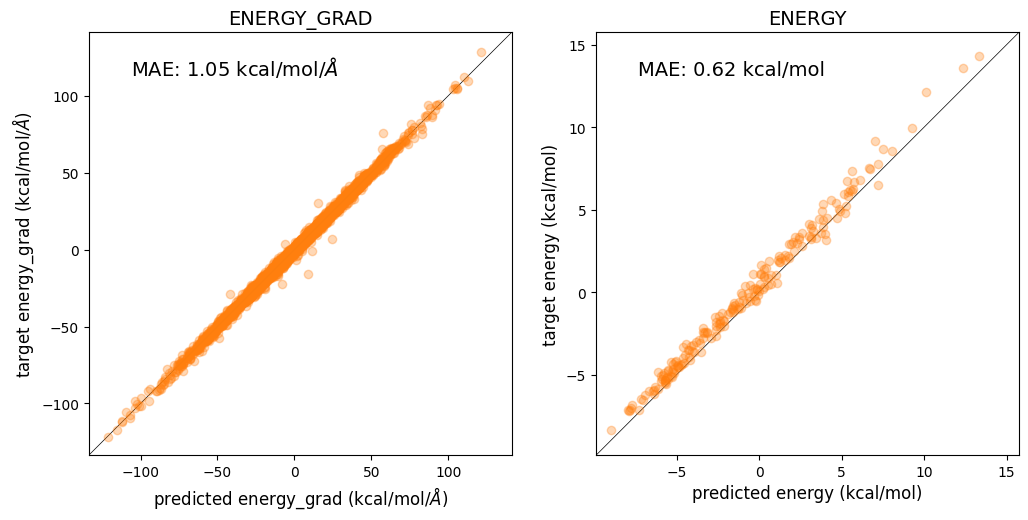

In [13]:
results, targets, val_loss = evaluate(T.get_best_model(), test_loader, loss_fn, device=DEVICE)


units = {"energy_grad": r"kcal/mol/$\AA$", "energy": "kcal/mol"}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred_fn = torch.cat
    targ_fn = torch.cat
    if all([len(i.shape) == 0 for i in results[key]]):
        pred_fn = torch.stack
    if all([len(i.shape) == 0 for i in targets[key]]):
        targ_fn = torch.stack

    pred = pred_fn(results[key], dim=0).view(-1).detach().cpu().numpy()
    targ = targ_fn(targets[key], dim=0).view(-1).detach().cpu().numpy()

    mae = abs(pred - targ).mean()

    ax.scatter(pred, targ, color="#ff7f0e", alpha=0.3)

    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1

    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect("equal")

    ax.plot((lim_min, lim_max), (lim_min, lim_max), color="#000000", zorder=-1, linewidth=0.5)

    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel("predicted %s (%s)" % (key, units[key]), fontsize=12)
    ax.set_ylabel("target %s (%s)" % (key, units[key]), fontsize=12)
    ax.text(0.1, 0.9, "MAE: %.2f %s" % (mae, units[key]), transform=ax.transAxes, fontsize=14)

plt.show()

**Note**: In this example you have to train DimeNet++ for longer than DimeNet to get comparable performance. But if you do then DimeNet++ is only a bit worse than DimeNet. For example, after 500 epochs the errors are: 
- DimeNet++: 0.49 kcal/mol/A force MAE and 0.10 kcal/mol energy MAE
- DimeNet: 0.32 kcal/mol/A force MAE and 0.07 kcal/mol energy MAE

The DimeNet++ paper claims that it does even better than DimeNet on QM9, so I'm not sure if the worse performance here is an issue with my implementation, or if it could be because of the small system we're using (ethanol).

# For fun: visualizing the basis functions
We can look at the radial and spherical basis functions to see what they look like. We can build the radial functions ourselves and compare them with and without the polynomial envelope: 

In [14]:
from nff.nn.layers import Envelope

envelope_p = 5
envelope = Envelope(envelope_p)

Layers with and without envelope function:

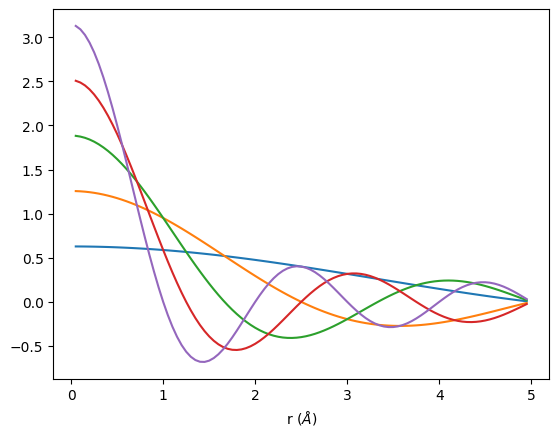

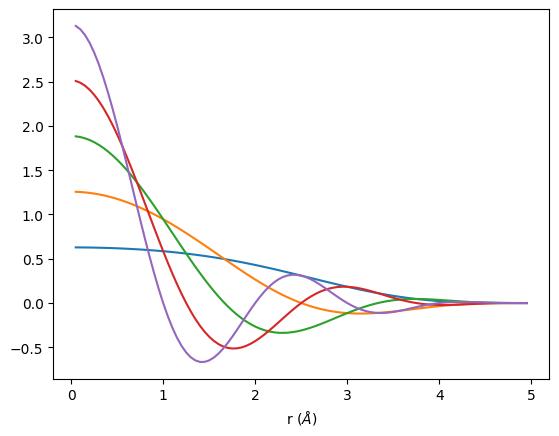

In [15]:
cutoff = 5.0

n_rbf = 5
d = torch.arange(0, cutoff, 0.05).reshape(-1, 1)
n = torch.arange(1, n_rbf + 1).float()
k_n = n * np.pi / cutoff
env = envelope(d / 5)

arg = torch.sin(k_n * d) / d
plt.plot(d, arg)
plt.xlabel("r ($\AA$)")
plt.show()

plt.plot(d, arg * env)
plt.xlabel("r ($\AA$)")

plt.show()

We can also get the layers directly from the module `DimeNetRadialBasis`:

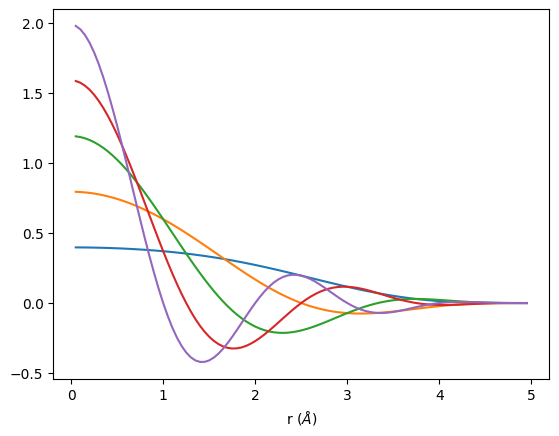

In [16]:
from nff.nn.layers import DimeNetRadialBasis, DimeNetSphericalBasis

dime_rbf = DimeNetRadialBasis(n_rbf=n_rbf, cutoff=cutoff, envelope_p=envelope_p)
out = dime_rbf(d)
plt.plot(d, out.detach().numpy())
plt.xlabel("r ($\AA$)")
plt.show()

Let's take a look at spherical basis functions, which we get from the `DimeNetSphericalBasis` module. First instantiate the module:

In [17]:
n_spher = 4
l_spher = 4
dime_sbf = DimeNetSphericalBasis(l_spher=l_spher, n_spher=n_spher, cutoff=5.0, envelope_p=6)

Then make an x-y grid, calculate the distances and angles at each point on the grid, get the radial and angular parts of the spherical basis functions, and plot their product:

In [18]:
self = dime_sbf

pos_x = torch.arange(0.05, self.cutoff * 1.2, 0.05)
neg_x = torch.arange(-self.cutoff * 1.2, -0.05, 0.05)

x = torch.cat([neg_x, pos_x])
y = torch.cat([neg_x, pos_x])


xv, yv = np.meshgrid(x, y)
xv = torch.Tensor(xv)
yv = torch.Tensor(yv)

angles = torch.atan2(input=xv, other=yv)
d = (xv**2 + yv**2) ** 0.5

d_scaled = d / self.cutoff
rbf = [f(d_scaled) for f in self.bessel_funcs]
rbf = torch.stack(rbf, dim=1)

u = self.envelope(d_scaled)
cbf = [f(angles) for f in self.sph_funcs]
cbf = torch.stack(cbf, dim=1)

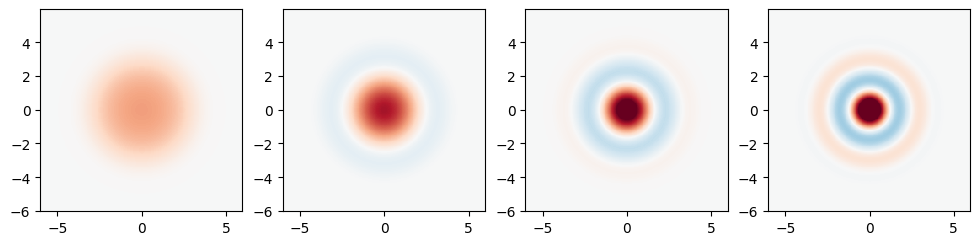

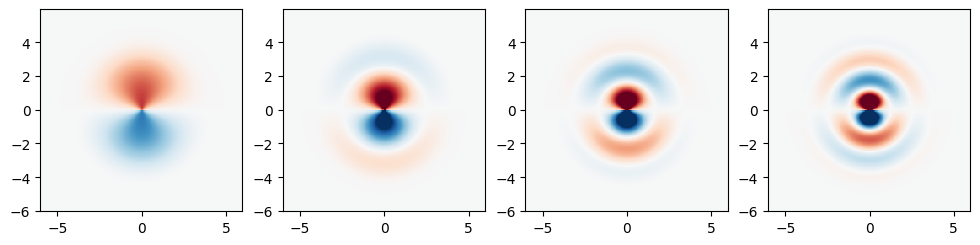

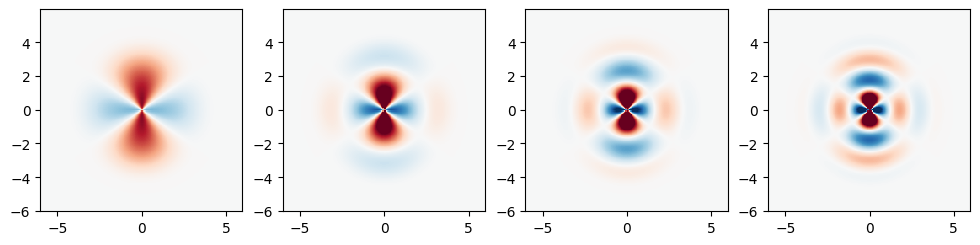

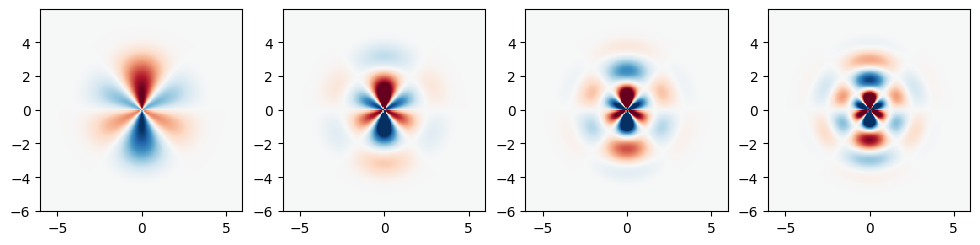

In [19]:
for l in range(l_spher):
    totals = []
    for n in range(n_spher):
        total = cbf[:, l, :] * rbf[:, n, :] * u
        mask = np.heaviside(cutoff - d, 0)
        totals.append(total * mask)

    fig, ax_fig = plt.subplots(1, n_spher, figsize=(12, 6))

    for i, ax in enumerate(ax_fig):
        z = -totals[i].numpy()
        mesh = ax.pcolormesh(xv, yv, z, cmap="RdBu", vmin=-3, vmax=3)
        ax.set_aspect(1)